In [1]:
import re
import os
import pickle
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import datetime
import joblib
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.dummy import DummyClassifier

from scipy.stats import wilcoxon
from scipy.stats import ranksums


from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [2]:
PATH = "drive/MyDrive/OrlyPred/Homomer_embeds/results/tabs_final_feb23/"

In [3]:
proba_pred_actual = pd.read_pickle(PATH + "proba_pred_actual.pkl")
y_prob_with_overall_train = pd.read_pickle(PATH + "y_prob_with_overall_train.pkl")
overall_proba_pred_ecod = pd.read_csv(PATH + "overall_proba_pred_ecod.csv", sep="\t")
qsbio_file = "drive/MyDrive/OrlyPred/Data/QSbio_PiQSi_annotations_V6_2020.csv"
qsbio_df = pd.read_csv(qsbio_file, error_bad_lines=False, low_memory=False, skiprows=21)
qsbio_df = qsbio_df.drop(["Unnamed: 18", "Unnamed: 19", "Unnamed: 20", "Unnamed: 21"], axis=1)

overall_train_set = pd.read_pickle(PATH + "train_set_c0.3.pkl")
hold_out_set = pd.read_pickle(PATH + "hold_out_set_c0.3.pkl")


/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
overall_proba_pred_ecod

,Unnamed: 0,nsub,1,2,3,4,5,6,7,8,...,pdb_range,seqid_range,unp_acc,arch_name,x_name,h_name,t_name,f_name,asm_status,seq_length
0,0,1.0,0.783307,0.201996,1.216337e-02,8.011185e-05,2.807020e-11,4.205513e-05,1.008026e-08,2.411538e-03,...,A:30-330,A:2-302,C4ZBG5,beta duplicates or obligate multimers,beta-propeller-like,beta-propeller,7-bladed,Lactonase_2,NOT_DOMAIN_ASSEMBLY,300.0
1,1,1.0,0.832748,0.167252,4.030858e-12,1.128904e-09,2.083922e-12,1.043295e-11,3.965986e-18,1.826864e-25,...,A:1485-1537,A:7-59,Q12888,beta barrels,SH3,SH3,SH3,53-BP1_Tudor_N,NOT_DOMAIN_ASSEMBLY,52.0
2,2,1.0,0.619186,0.380783,2.033595e-05,1.882209e-06,1.610682e-06,3.620154e-09,3.769663e-07,1.717904e-09,...,A:197-344,A:176-323,A7M003,beta barrels,Lipocalins/Streptavidin,NO_H_NAME,Uncharacterized protein BACOVA_03322 C-termina...,EUF07602,NOT_DOMAIN_ASSEMBLY,147.0
3,3,1.0,0.204977,0.149558,1.099072e-06,6.451779e-01,6.787253e-06,2.148039e-04,1.128096e-05,2.705112e-09,...,B:-1-144,B:1-146,O43924,beta sandwiches,Immunoglobulin-like beta-sandwich,Immunoglobulin-related,Immunoglobulin/Fibronectin type III/E set doma...,GMP_PDE_delta,NOT_DOMAIN_ASSEMBLY,145.0
4,4,1.0,0.293689,0.654100,3.801573e-02,4.010318e-03,3.807144e-05,2.018026e-04,3.553152e-07,5.239235e-09,...,A:2-168,A:1-165,Q6V8M0,beta sandwiches,jelly-roll,Concanavalin A-like,Galactose-binding domain-like,CBM_4_9_1,NOT_DOMAIN_ASSEMBLY,164.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13613,13613,2.0,0.940131,0.059868,6.749282e-09,1.203473e-07,9.552977e-15,9.275516e-07,1.617767e-12,1.801258e-11,...,B:164-282,B:164-282,Q9RYW8,alpha arrays,NO_X_NAME,NO_H_NAME,DNA-binding domain in UvrA,uvrA_2nd_1,NOT_DOMAIN_ASSEMBLY,118.0
13614,13614,2.0,0.000008,0.999826,7.316820e-13,1.667813e-04,6.891503e-20,5.941285e-21,5.418159e-16,9.616596e-13,...,D:0-146,D:3-149,Q5HKZ1,alpha arrays,HTH,HTH,winged,MarR,NOT_DOMAIN_ASSEMBLY,146.0
13615,13615,2.0,0.027929,0.972025,2.263788e-06,4.350528e-05,5.775740e-12,3.471968e-11,2.248224e-10,4.253198e-08,...,A:0-308,A:3-311,Q8Y4H9,a/b barrels,TIM beta/alpha-barrel,NO_H_NAME,TIM barrels,Peptidase_M19,NOT_DOMAIN_ASSEMBLY,308.0
13616,13616,2.0,0.173492,0.822645,3.832921e-03,2.961943e-05,1.114437e-15,1.423381e-07,1.155645e-14,2.565074e-16,...,A:962-1080,A:8-126,F4Y425,a+b two layers,Thioesterase/thiol ester dehydrase-isomerase-like,NO_H_NAME,Thioesterase/thiol ester dehydrase-isomerase,PS-DH_N,NOT_DOMAIN_ASSEMBLY,118.0


In [5]:
qsbio_df['nsub'] = pd.to_numeric(qsbio_df['nsub'], errors='coerce', downcast="integer")
merged_ecod_qsbio = overall_proba_pred_ecod.merge(qsbio_df, on=["code", "nsub"], how="outer")

In [6]:
merged_ecod_qsbio

,Unnamed: 0,nsub,1,2,3,4,5,6,7,8,...,corrected_nsub,corrected_sym,h_40_repre,h_90_repre,Ig,piqsi_annot,PiQSi_correction_comment,PISA_identical,EPPIC_identical,best_BU
0,0.0,1.0,0.783307,0.201996,1.216337e-02,8.011185e-05,2.807020e-11,4.205513e-05,1.008026e-08,2.411538e-03,...,NaN,NaN,1,1,0.0,NaN,NaN,1,1,1
1,1.0,1.0,0.832748,0.167252,4.030858e-12,1.128904e-09,2.083922e-12,1.043295e-11,3.965986e-18,1.826864e-25,...,NaN,NaN,0,0,0.0,NaN,NaN,1,1,1
2,2.0,1.0,0.619186,0.380783,2.033595e-05,1.882209e-06,1.610682e-06,3.620154e-09,3.769663e-07,1.717904e-09,...,NaN,NaN,1,1,0.0,NaN,NaN,1,1,1
3,3.0,1.0,0.204977,0.149558,1.099072e-06,6.451779e-01,6.787253e-06,2.148039e-04,1.128096e-05,2.705112e-09,...,NaN,NaN,0,0,0.0,NaN,NaN,1,1,1
4,4.0,1.0,0.293689,0.654100,3.801573e-02,4.010318e-03,3.807144e-05,2.018026e-04,3.553152e-07,5.239235e-09,...,NaN,NaN,0,0,0.0,NaN,NaN,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210675,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0.0,NaN,NaN,1,1,1
210676,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,1,0.0,NaN,NaN,0,0,NaN
210677,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,0.0,NaN,NaN,1,1,2
210678,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,D2,0,0,0.0,NO,-- Annotation transfered from 4xis,1,1,1


In [7]:
def code_mod(code_string):
    pdb_code = str(code_string.split("_")[0])
    modified_code = pdb_code
    return modified_code

merged_ecod_qsbio['pdb'] = merged_ecod_qsbio['code'].apply(lambda x: code_mod(x))


In [8]:
merged_ecod_qsbio.groupby("pdb").count().sort_values(by=["code", "nsub"])

,Unnamed: 0,nsub,1,2,3,4,5,6,7,8,...,corrected_nsub,corrected_sym,h_40_repre,h_90_repre,Ig,piqsi_annot,PiQSi_correction_comment,PISA_identical,EPPIC_identical,best_BU
pdb,,,,,,,,,,,,,,,,,,,,,
100d,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
101d,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
102d,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
109d,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
110d,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5mu8,0,24,0,0,0,0,0,0,0,0,...,24,24,24,24,24,0,0,24,24,24
4n3e,0,28,0,0,0,0,0,0,0,0,...,0,0,28,28,28,0,0,28,28,28
5lhy,0,30,0,0,0,0,0,0,0,0,...,0,0,30,30,30,0,0,30,30,30


In [9]:
# tab of pdbs that are in the train set
merged_ecod_qsbio_in_train = merged_ecod_qsbio[merged_ecod_qsbio["pdb"].isin(overall_proba_pred_ecod.pdb)]

# grouped tab of multi-label pdbs 
merged_ecod_qsbio_in_train.groupby("pdb").count()[merged_ecod_qsbio_in_train.groupby("pdb").count()["code"] >1].sort_values(by="code")


,Unnamed: 0,nsub,1,2,3,4,5,6,7,8,...,corrected_nsub,corrected_sym,h_40_repre,h_90_repre,Ig,piqsi_annot,PiQSi_correction_comment,PISA_identical,EPPIC_identical,best_BU
pdb,,,,,,,,,,,,,,,,,,,,,
1a8q,1,2,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,1
3ge9,1,2,1,1,1,1,1,1,1,1,...,2,2,2,2,2,0,0,2,2,1
3gjd,1,2,1,1,1,1,1,1,1,1,...,0,0,2,2,2,0,0,2,2,1
3gku,1,2,1,1,1,1,1,1,1,1,...,0,0,2,2,2,0,0,2,2,1
3gq9,1,2,1,1,1,1,1,1,1,1,...,0,0,2,2,2,0,0,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2dg1,1,7,1,1,1,1,1,1,1,1,...,0,0,7,7,7,0,0,7,7,1
1zye,1,8,1,1,1,1,1,1,1,1,...,8,8,8,8,8,0,0,8,8,1
1hqz,1,10,1,1,1,1,1,1,1,1,...,0,0,10,10,10,0,0,10,10,1


In [10]:
merged_ecod_qsbio_in_train[merged_ecod_qsbio_in_train["pdb"] == "1al7"][["nsub", "1_pred", "2_pred", "3_pred", "QSBIO_err_prob"]]

,nsub,1_pred,2_pred,3_pred,QSBIO_err_prob
10593,8.0,4.0,2.0,6.0,7.7
14473,4.0,NaN,NaN,NaN,79.5


In [11]:
merged_ecod_qsbio_in_train[merged_ecod_qsbio_in_train["pdb"] == "5dm3"][["nsub", "1_pred", "2_pred", "3_pred", "QSBIO_err_prob"]]

,nsub,1_pred,2_pred,3_pred,QSBIO_err_prob
4540,12.0,12.0,6.0,14.0,0
168810,1.0,NaN,NaN,NaN,25
168811,2.0,NaN,NaN,NaN,94
168812,2.0,NaN,NaN,NaN,94
168813,1.0,NaN,NaN,NaN,25
168814,1.0,NaN,NaN,NaN,25
168815,1.0,NaN,NaN,NaN,25
168816,1.0,NaN,NaN,NaN,25
168817,1.0,NaN,NaN,NaN,25
168818,2.0,NaN,NaN,NaN,94


In [12]:
# make list of multi-labels pdbs and then generate tabs of single and multi label
pdbs_more_than_1_label = merged_ecod_qsbio_in_train.groupby("pdb").count()[merged_ecod_qsbio_in_train.groupby("pdb").count()["code"] >1].index.to_list()
merged_ecod_qsbio_multilabel = merged_ecod_qsbio_in_train[merged_ecod_qsbio_in_train["pdb"].isin(pdbs_more_than_1_label)]
merged_ecod_qsbio_multilabel_only_highest = merged_ecod_qsbio_multilabel.dropna(subset=["1_pred"])
merged_ecod_qsbio_singlelabel = merged_ecod_qsbio_in_train[~merged_ecod_qsbio_in_train["pdb"].isin(pdbs_more_than_1_label)]


In [13]:
singlelabel_bal_acc = round(metrics.balanced_accuracy_score(merged_ecod_qsbio_singlelabel['nsub'].astype(int), merged_ecod_qsbio_singlelabel["1_pred"].astype(int)), 3)
# gen_con_mat_and_fig(metrics.confusion_matrix(overall_proba_pred_ecod['nsub'].astype(int), overall_proba_pred_ecod["1_pred"].astype(int)), PATH,
#                     ("regular_confusion_matrix Adjusted_balanced_accuracy: " + str(regular_bal_acc)), inv_map)
miltilelabel_bal_acc = round(metrics.balanced_accuracy_score(merged_ecod_qsbio_multilabel_only_highest['nsub'].astype(int), merged_ecod_qsbio_multilabel_only_highest["1_pred"].astype(int)), 3)
# gen_con_mat_and_fig(metrics.confusion_matrix(overall_proba_pred_ecod['nsub'].astype(int), overall_proba_pred_ecod["1_pred"].astype(int)), PATH,
#                     ("regular_confusion_matrix Adjusted_balanced_accuracy: " + str(regular_bal_acc)), inv_map)
print("singlelabel_bal_acc", singlelabel_bal_acc)
print("miltilelabel_bal_acc", miltilelabel_bal_acc)

singlelabel_bal_acc 0.361
miltilelabel_bal_acc 0.348


In [14]:
merged_ecod_qsbio_multilabel

,Unnamed: 0,nsub,1,2,3,4,5,6,7,8,...,corrected_nsub,corrected_sym,h_40_repre,h_90_repre,Ig,piqsi_annot,PiQSi_correction_comment,PISA_identical,EPPIC_identical,best_BU
26,26.0,4.0,9.653928e-01,0.027627,6.085435e-05,8.807964e-06,6.252305e-06,0.006879,2.543350e-05,4.544691e-12,...,4,D2,0,0,0.0,NaN,NaN,0,0,1
38,38.0,8.0,9.299792e-07,0.086468,4.316854e-02,9.234274e-07,3.590954e-02,0.028327,7.546272e-08,8.061251e-01,...,8,D4,1,1,0.0,NaN,NaN,0,0,1
44,44.0,3.0,1.734827e-04,0.971644,2.816869e-02,1.129591e-05,1.452492e-11,0.000003,1.176246e-13,2.651574e-09,...,3,C3,1,1,0.0,NO,-- Annotation transfered from 1rxm,0,0,1
48,48.0,4.0,6.361470e-05,0.609734,2.708239e-03,3.874308e-01,1.380363e-07,0.000019,9.163998e-11,1.130245e-05,...,4,D2,0,0,0.0,NO,paper says homotetramer -- Annotation transfer...,0,0,1
49,49.0,4.0,5.440393e-01,0.359884,2.243331e-10,9.606694e-02,9.880357e-19,0.000009,2.761551e-09,1.153253e-16,...,4,D2,0,0,0.0,NaN,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195148,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,D2,1,0,0.0,NaN,NaN,0,1,NaN
195149,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,D2,0,1,0.0,NaN,NaN,0,0,NaN
195150,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4,D2,1,0,0.0,NaN,NaN,0,0,NaN
210627,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,C2,0,0,0.0,NaN,NaN,0,0,NaN


In [15]:
# merged_ecod_qsbio_multilabel["additinal_nsub"] = np.where(merged_ecod_qsbio_multilabel["nsub"] == "1_pred", )

In [16]:
merged_ecod_qsbio_multilabel_with_all_labels = pd.DataFrame()
for pdb_entry in pdbs_more_than_1_label:
  tab = merged_ecod_qsbio_multilabel[merged_ecod_qsbio_multilabel["pdb"] == pdb_entry]
  # print(tab.nsub.unique().tolist()[0])
  # tab["additional_labels"] = [tab.nsub.unique().tolist()]
  # print(tab[["nsub", "code", "QSBIO_err_prob", "1_pred"]])
  pd.concat([merged_ecod_qsbio_multilabel_with_all_labels, tab], axis=1)
print(merged_ecod_qsbio_multilabel_with_all_labels)


Empty DataFrame
Columns: []
Index: []


RanksumsResult(statistic=19.8432781123438, pvalue=6.298537684721606e-88) wilcoxon for 1
RanksumsResult(statistic=8.826491435925902, pvalue=5.400530796329453e-19) wilcoxon for 2
RanksumsResult(statistic=11.629733472890177, pvalue=1.455023754388833e-31) wilcoxon for 3
RanksumsResult(statistic=12.211382985428237, pvalue=1.3512791277550578e-34) wilcoxon for 4
RanksumsResult(statistic=4.865455315462779, pvalue=5.709680490408757e-07) wilcoxon for 5
RanksumsResult(statistic=4.838819582030342, pvalue=6.530627176437654e-07) wilcoxon for 6
RanksumsResult(statistic=nan, pvalue=nan) wilcoxon for 7
RanksumsResult(statistic=7.3556476379649185, pvalue=9.500180984321202e-14) wilcoxon for 8
RanksumsResult(statistic=2.5893554998805985, pvalue=0.004807788469942265) wilcoxon for 10
RanksumsResult(statistic=8.851195288006862, pvalue=4.329344750733796e-19) wilcoxon for 12
RanksumsResult(statistic=nan, pvalue=nan) wilcoxon for 14
RanksumsResult(statistic=1.7522987960251157, pvalue=0.03986122148412104) wilcox

/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:8504: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  anchor: (float, float) or {'C', 'SW', 'S', 'SE', 'E', 'NE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or float
  autoscale_on: bool
  autoscalex_on: bool
  autoscaley_on: bool
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  box_aspect: float or None
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  facecolor or fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  rasterized: bool
  sketch_p

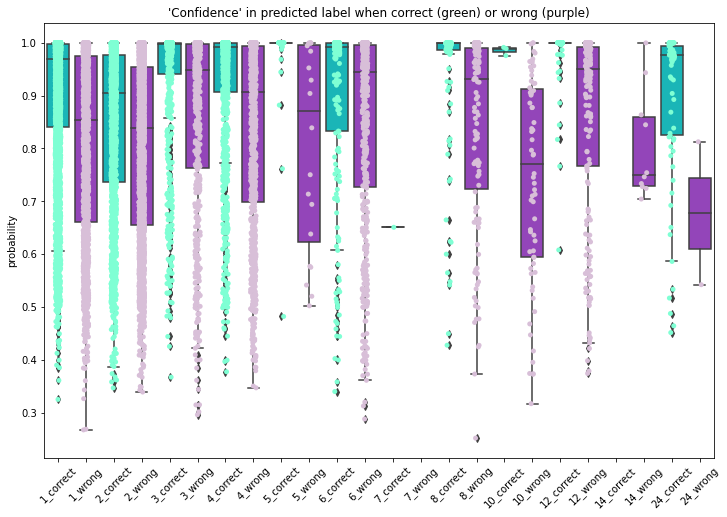

In [17]:
distribution_df = pd.DataFrame(index=range(overall_proba_pred_ecod.shape[0]))
for chosen_nsub in sorted(overall_proba_pred_ecod.nsub.unique().tolist()):
    chosen_df = overall_proba_pred_ecod[overall_proba_pred_ecod["1_pred"] == chosen_nsub][["nsub", "1_pred", str(int(chosen_nsub))]]
    chosen_df_true = chosen_df[chosen_df["nsub"] == chosen_nsub]
    chosen_df_wrong = chosen_df[chosen_df["nsub"] != chosen_nsub]
    distribution_df[str(int(chosen_nsub)) + "_correct"] = chosen_df_true[str(int(chosen_nsub))]
    distribution_df[str(int(chosen_nsub)) + "_wrong"] = chosen_df_wrong[str(int(chosen_nsub))]
    print(ranksums(chosen_df_true[str(int(chosen_nsub))], chosen_df_wrong[str(int(chosen_nsub))], alternative='greater'), "wilcoxon for " + str(int(chosen_nsub)))
fig, ax = plt.subplots(figsize=(12, 8))
plt.setp(sns.boxplot(data=distribution_df, palette=["darkturquoise", "darkorchid"]).get_xticklabels(), rotation=45)
plt.setp(sns.stripplot(data=distribution_df, palette=["aquamarine", "thistle"]))
ax.set_ylabel("probability")
ax.set_title("'Confidence' in predicted label when correct (green) or wrong (purple)")
plt.show()
plt.close()



In [18]:
chosen_df_true
chosen_df_wrong[str(int(chosen_nsub))]

8462     0.812657
13426    0.542271
Name: 24, dtype: float64

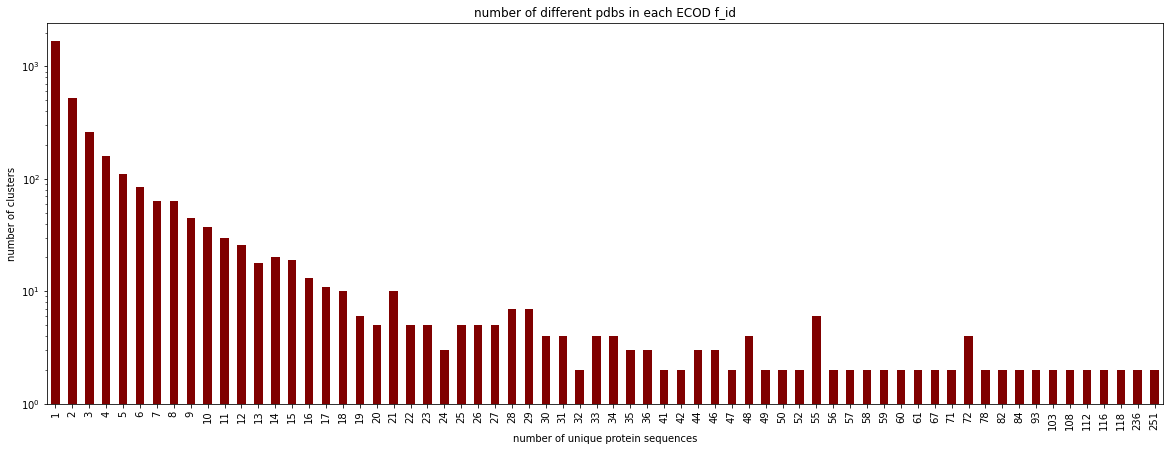

In [19]:
b = overall_proba_pred_ecod.groupby("f_id").nunique("code").groupby("code").size().plot\
    (kind='bar', color="maroon", figsize=[20,7], fontsize=10, log=True, grid=False,
      title="number of different pdbs in each ECOD f_id", xlabel="number of unique protein sequences", ylabel="number of clusters")
# b.figure.savefig(PATH + "number_of_unique_pdbs_per_cluster_f_id.png")
plt.show()

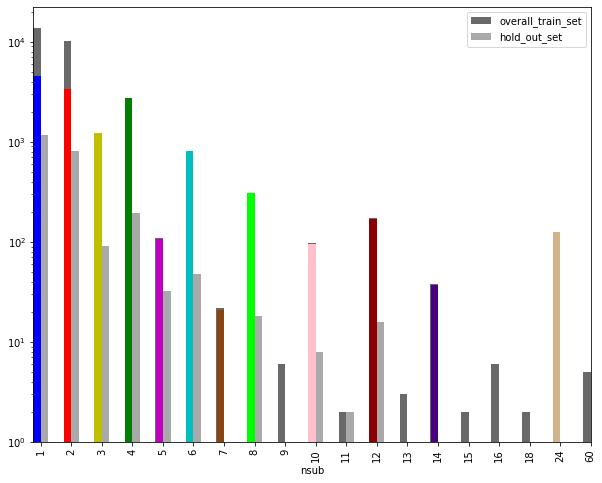

In [20]:
num_qs_overall = overall_train_set.drop("esm_embeddings", axis=1).groupby("nsub").nunique("code")["code"]
num_qs_training = overall_proba_pred_ecod.groupby("nsub").nunique("code")["code"]
num_qs_holdout = hold_out_set.drop("esm_embeddings", axis=1).groupby("nsub").nunique("code")["code"]
tab_nsub_num = pd.concat([num_qs_training, num_qs_overall, num_qs_holdout], axis=1)
tab_nsub_num.columns.values[0] = "used_for_training"
tab_nsub_num.columns.values[1] = "overall_train_set"
tab_nsub_num.columns.values[2] = "hold_out_set"
tab_nsub_num.index = tab_nsub_num.index.astype(int)
tab_nsub_num[["overall_train_set", "hold_out_set"]].plot(kind="bar", figsize=(10, 8), log=True, color=["dimgray", "darkgray"])
#plt.show()
#plt.close()
tab_nsub_num.head()
colors = ['b', 'r', 'y', 'g', 'm', 'c', 'saddlebrown', 'lime', "midnightblue", 'pink', 'gray', 'darkred', 'orange', 'indigo', 'teal', 'peru', 'lightgreen', 'tan', 'k']
tab_nsub_num.used_for_training.plot(kind="bar", color=colors, figsize=(10, 8), log=True, width=-0.24, align="edge")
plt.show()

In [21]:
tab_nsub_num.index = tab_nsub_num.index.astype(int)
tab_nsub_num

,used_for_training,overall_train_set,hold_out_set
nsub,,,
1,4593.0,13779,1175.0
2,3384.0,10153,814.0
3,1217.0,1217,91.0
4,2743.0,2743,194.0
5,108.0,108,32.0
6,816.0,816,48.0
7,21.0,21,1.0
8,307.0,307,18.0
9,NaN,5,1.0


In [22]:
# network graph - each node is qs. Edge width is number of families with shared qs
unique_nsub = overall_proba_pred_ecod["nsub"].unique().astype("int")
family_nsub_count = overall_proba_pred_ecod.groupby(["f_id", "nsub"]).count()["code"].reset_index()

import itertools
list_intersect = []
for nsub1, nsub2 in itertools.product(unique_nsub, unique_nsub):
    family_nsub1 = family_nsub_count[family_nsub_count["nsub"] == nsub1]["f_id"]
    family_nsub2 = family_nsub_count[family_nsub_count["nsub"] == nsub2]["f_id"]
    intersect_size = len(set(family_nsub1) & set(family_nsub2))
    if intersect_size > 0:
      list_intersect.append([nsub1, nsub2, intersect_size])

In [23]:
nsub_overall_dict = tab_nsub_num.used_for_training.dropna().to_dict()
nsub_overall_dict = {i: "%d" % round(100*nsub_overall_dict[i]/sum(nsub_overall_dict.values()), 2) + "%" for i in nsub_overall_dict.keys()}
node_names = {i: int(i) for i in nsub_overall_dict.keys()}
nsub_overall_dict

{1: '33%',
 2: '24%',
 3: '8%',
 4: '20%',
 5: '0%',
 6: '5%',
 7: '0%',
 8: '2%',
 10: '0%',
 12: '1%',
 14: '0%',
 24: '0%'}

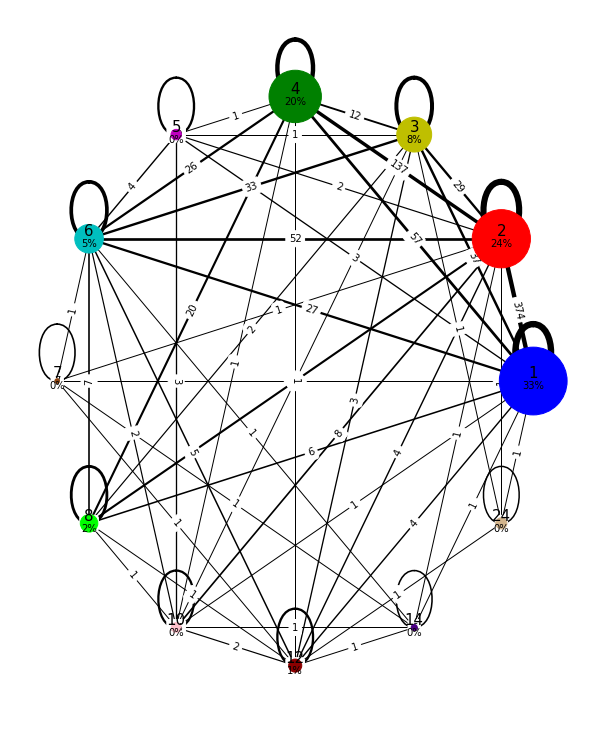

In [30]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(sorted(unique_nsub))
G.add_weighted_edges_from(list_intersect)
# for line in list_intersect:
#   G.add_edge(line[0], line[1]) 
nsub_overall_count = tab_nsub_num.used_for_training.dropna().to_list()
pos=nx.circular_layout(G)
weights = [i**0.25 for i in list(nx.get_edge_attributes(G,'weight').values())]
plt.figure(1,figsize=(8,10)) 
# the colors are not correct. TODO remove unused qs
color_12_classes = ['b', 'r', 'y', 'g', 'm', 'c', 'saddlebrown', 'lime', 'pink', 'darkred', 'indigo', 'tan']
nx.draw(G, font_weight='bold', node_size=nsub_overall_count, pos=pos, width=weights, node_color=color_12_classes)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

nx.draw_networkx_labels(G, pos, nsub_overall_dict, font_size=10, font_color="k", verticalalignment="top")
nx.draw_networkx_labels(G, pos, node_names, font_size=15, font_color="k", verticalalignment="bottom")

plt.show()

<AxesSubplot:xlabel='nsub2', ylabel='nsub1'>

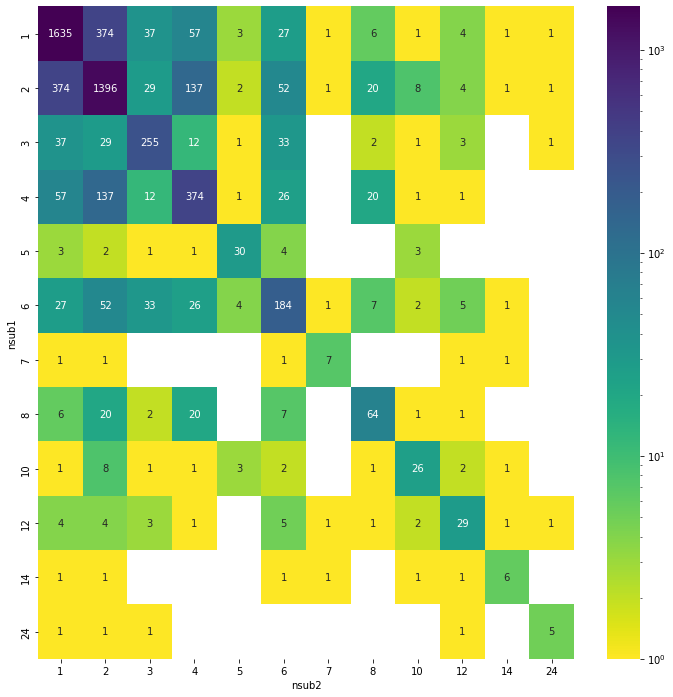

In [25]:
# heatmap for the same data
df_intersect = pd.DataFrame(list_intersect, columns=["nsub1", "nsub2", "num_of_families"])
result = df_intersect.pivot(index='nsub1',columns='nsub2',values='num_of_families')
from matplotlib.colors import LogNorm
plt.figure(1,figsize=(12,12)) 
sns.heatmap(result, cmap="viridis_r", norm=LogNorm(), annot=True, fmt="g")


In [26]:
overall_proba_pred_ecod.groupby(["f_id", "nsub"]).count()

Unnamed: 0   1   2   3   4   5   6   7   8  10  ...  \
f_id      nsub                                                  ...   
1.1.1.30  2.0            6   6   6   6   6   6   6   6   6   6  ...   
1.1.1.31  1.0            2   2   2   2   2   2   2   2   2   2  ...   
1.1.1.37  2.0            1   1   1   1   1   1   1   1   1   1  ...   
1.1.1.4   1.0            3   3   3   3   3   3   3   3   3   3  ...   
          2.0           55  55  55  55  55  55  55  55  55  55  ...   
...                    ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   
920.1.1.1 1.0            1   1   1   1   1   1   1   1   1   1  ...   
          2.0            1   1   1   1   1   1   1   1   1   1  ...   
922.1.1.4 1.0            3   3   3   3   3   3   3   3   3   3  ...   
926.1.1.1 2.0            1   1   1   1   1   1   1   1   1   1  ...   
929.1.1.1 3.0            2   2   2   2   2   2   2   2   2   2  ...   

                pdb_range  seqid_range  unp_acc  arch_name  x_name  h_name  \
f_id      nsub                                                               
1.1.1.30  2.0           6            6        6          6       6       6   
1.1.1.31  1.0           2            2        2          2       2       2   
1.1.1.37  2.0           1            1        1          1       1       1   
1.1.1.4   1.0           3            3        3          3       3       3   
          2.0          55           55       55         55      55      55   
...                   ...          ...      ...        ...     ...     ...   
920.1.1.1 1.0           1            1        1          1       1       1   
          2.0           1            1        1          1       1       1   
922.1.1.4 1.0           3            3        3          3       3       3   
926.1.1.1 2.0           1            1        1          1       1       1   
929.1.1.1 3.0           2            2        2          2       2       2   

                t_name  f_name  asm_status  seq_length  
f_id      nsub                                          
1.1.1.30  2.0        6       6           6           6  
1.1.1.31  1.0        2       2           2           2  
1.1.1.37  2.0        1       1           1           1  
1.1.1.4   1.0        3       3           3           2  
          2.0       55      55          55          55  
...                ...     ...         ...         ...  
920.1.1.1 1.0        1       1           1           1  
          2.0        1       1           1           1  
922.1.1.4 1.0        3       3           3           3  
926.1.1.1 2.0        1       1           1           1  
929.1.1.1 3.0        2       2           2           2  

[4011 rows x 34 columns]

In [27]:
multi_qs_clust = overall_proba_pred_ecod.groupby("f_id").nunique()[overall_proba_pred_ecod.groupby("f_id")
                                                                                    .nunique().nsub > 1].sort_values("nsub")
relevant_clusters = multi_qs_clust[["nsub"]]
multi_qs_tab = overall_proba_pred_ecod[overall_proba_pred_ecod["f_id"].isin(relevant_clusters.index)]
overall_proba_pred_ecod.groupby("f_id").nunique()[overall_proba_pred_ecod.groupby("f_id").nunique().nsub > 2].sort_values("nsub").head(10)

,Unnamed: 0,nsub,1,2,3,4,5,6,7,8,...,pdb_range,seqid_range,unp_acc,arch_name,x_name,h_name,t_name,f_name,asm_status,seq_length
f_id,,,,,,,,,,,,,,,,,,,,,
1.1.5.147,20,3,20,20,20,20,20,20,20,20,...,18,18,9,1,1,1,1,1,1,17
304.10.1.2,12,3,12,12,12,12,12,12,12,12,...,8,9,7,1,1,1,1,1,1,8
301.5.1.1,20,3,20,20,20,20,20,20,20,20,...,18,18,15,1,1,1,1,1,1,9
301.3.1.1,9,3,9,9,9,9,9,9,9,9,...,9,9,6,1,1,1,1,1,1,9
3009.1.1.8,3,3,3,3,3,3,3,3,3,3,...,3,3,3,1,1,1,1,1,1,2
284.1.1.2,11,3,11,11,11,11,11,11,11,11,...,10,10,11,1,1,1,1,1,1,7
271.1.1.2,103,3,103,103,103,103,103,103,103,103,...,70,85,29,1,1,1,1,1,1,25
257.1.1.1,8,3,8,8,8,8,8,8,8,8,...,8,8,6,1,1,1,1,1,1,6
2498.1.1.124,12,3,12,12,12,12,12,12,12,12,...,10,9,6,1,1,1,1,1,1,7


In [28]:
multi_qs_tab[multi_qs_tab["f_id"] == "2492.1.1.5"][["f_name", "code", "nsub", "1_pred"]]

,f_name,code,nsub,1_pred
3130,dCMP_cyt_deam_1,4p9d_1,6.0,6
3555,dCMP_cyt_deam_1,1z3a_1,2.0,2
3623,dCMP_cyt_deam_1,1uaq_1,2.0,2
3746,dCMP_cyt_deam_1,2b3z_1,4.0,2
6740,dCMP_cyt_deam_1,3r2n_1,4.0,3
6746,dCMP_cyt_deam_1,4f3w_1,4.0,4
6798,dCMP_cyt_deam_1,1mq0_1,4.0,2
6832,dCMP_cyt_deam_1,2d30_1,4.0,6
6936,dCMP_cyt_deam_1,3oj6_1,4.0,4
6964,dCMP_cyt_deam_1,3mpz_1,4.0,6


In [29]:
possible interseting examples:
304.10.1.2
2007.1.1.6
7531.1.1.1
170.1.1.8

SyntaxError: ignored

In [ ]:
very unsuccessful:
2002.1.1.702
243.1.1.9